# ARIMA and SARIMA

Apziva project #5<br>
2023 09 04

__Summary:__
* In this notebook the models ARIMA and SARIMA are explored.
* To do this, the __Microsoft stock market dataset__ is used:
    * 3 years training data
    * 8 months test data
* Furthermore, 2 x 3 = __6 datasets were simulated__:
    * General function: constant, linear, exponential.
    * Seasonality: without and with.
    * Noise added.
* Then the ARIMA / SARIMA parameters were estimated, using __auto-ARIMA__:
    * Stationarity was detected for the two constant simulations.
    * For all other datasets, the raw price data had to be differenced once (i.e. `d = 1`).
* Finally, ARIMA models where fitted.
    * For the __real Microsoft data__ an __ARIMA(0,1,1)__ was modeled, meaning
        * 0 autoregressive terms
        * 1 diffencing step
        * 1 lagged forecast error
        * __no parameters for seasonality__
    * In other words, an ARIMA(0,1,1) model... 
        * does __not use past values__ of the time series (no AR component),
        * it includes __one differencing step__ to make the data stationary (order 1 of the I component),
        * and it uses __one lagged error term__ (order 1 of the MA component) to make predictions.
* ARIMA predicted a __constant Microsoft stock market price__ and did not even predict a linear trend.
    * This does __not__ seem __reasonable__.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [Installation](#Installation)
* [Introduction](#Introduction)
* [Data](#Data)
    * [Load real data](#LoadRealData)
    * [Create artificial data](#CreateArtificialDta) 
* [Dickey-Fuller test](#DickeyFullerTest)   
* [ARIMA / SARIMA](#ArimaSarima)
    * [Auto-ARIMA: Best model parameters p, d, q](#AutoArima)
    * [Fit ARIMA](#FitArima)    

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## Installation <a class="anchor" id="Installation"></a>
[TOC](#TOC)

In [2]:
# installation
# pip install statsmodels
# pip install pmdarima

## Introduction <a class="anchor" id="Introduction"></a>
[TOC](#TOC)

__Term__
* ARIMA stands for: <b>A</b>uto</b> <b>R</b>egressive <b>I</b>ntegrated <b>M</b>oving <b>A</b>verage.
* ARIMA is a variant of ARMA, i.e. <b>A</b>uto</b> <b>R</b>egressive-<b>M</b>oving <b>A</b>verage.

__Variants of ARIMA__
* The ARIMA variants are defined by __three integer parameters p, d and q__.
* They are added in parentheses:
* Example: __ARIMA(1, 1, 2)__ can also be called a damped-trend linear exponential smoothing where we are applying 
    * __one time differencing__ (d, 2nd parameter) on the time series if it is non-stationary and after that, 
    * we are performing autoregression on the series with __one lag__ (p, 1st parameter) when the series is stationary by differencing 
    * and __2 average moving average order__ (q, 3rd parameter) is applied.
* Overview as a dataframe right below.

In [3]:
import pandas as pd
print("Overview on ARIMA elements".upper())
dlstr = {
    "Abbreviation": ["AR","I","MA"],
    "Full text": ["auto regressive","integrated","moving average"],
    "Type": ["model","method","model"],
    "Parameter": ["p","d","q"],
    "Long meaning": ["number of autoregressive terms","number of nonseasonal differences","number of lagged forecast errors"],
    "Short meaning": ["lag order","degree of differencing","order of moving average"],
}
pd.DataFrame(dlstr)

OVERVIEW ON ARIMA ELEMENTS


,Abbreviation,Full text,Type,Parameter,Long meaning,Short meaning
0,AR,auto regressive,model,p,number of autoregressive terms,lag order
1,I,integrated,method,d,number of nonseasonal differences,degree of differencing
2,MA,moving average,model,q,number of lagged forecast errors,order of moving average


__Sources:__
* General introduction: https://analyticsindiamag.com/comprehensive-guide-to-time-series-analysis-using-arima/
* Finding p, d and q: https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

## Data <a class="anchor" id="Data"></a>
[TOC](#TOC)

### Load real data <a class="anchor" id="LoadRealData"></a>
[TOC](#TOC)

In [4]:
import pickle
import pandas as pd

# Load your data
strFilename = f"../data/processed/dfrPredictionL2.p"
with open(strFilename, 'rb') as objBufferedWriter: # rb = read in binary mode
    dfrArima = pickle.load(objBufferedWriter)
dfrArima.drop("DifferenceL2",axis=1,inplace=True)
u.ShortDataFrameDisplay(dfrArima)

DataFrame 'dfrArima':


,Date,Price,Differences,PredDummy,PredL2
0,2020-01-01,153.010615,0.000000,153.010615,153.010615
1,2020-01-02,154.205344,1.194729,154.205344,154.205344
...,...,...,...,...,...
1343,2023-09-05,331.274994,0.322970,257.191823,245.520267
1344,2023-09-06,333.130005,1.855011,257.269338,245.547991


### Create artificial data <a class="anchor" id="CreateArtificialDta"></a>
[TOC](#TOC)

SIMULATED DATA


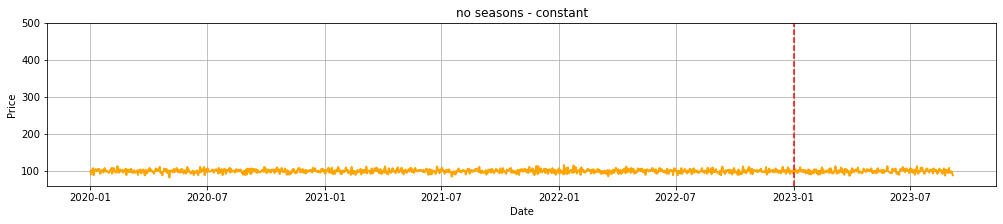

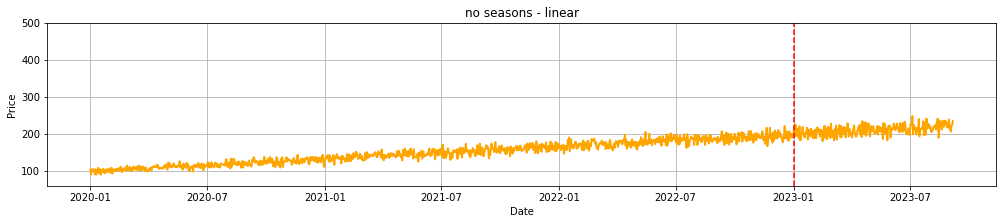

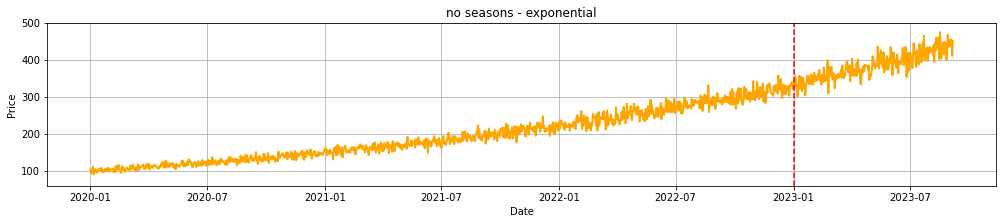

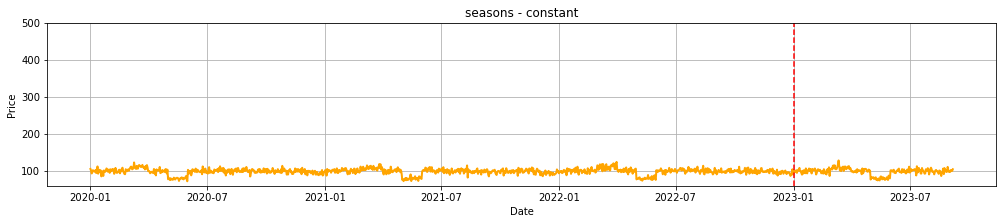

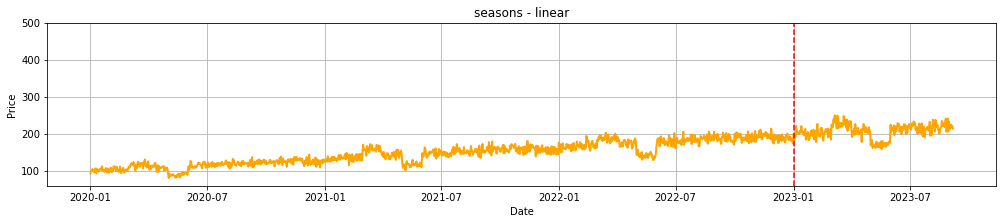

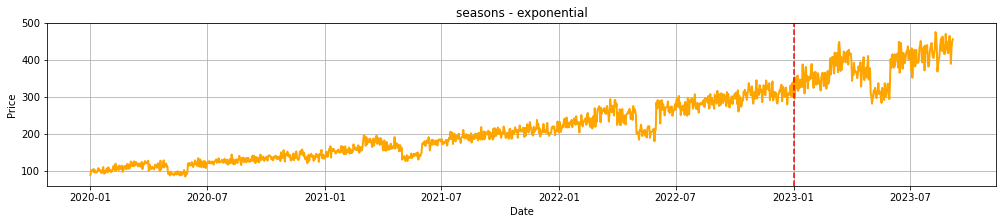

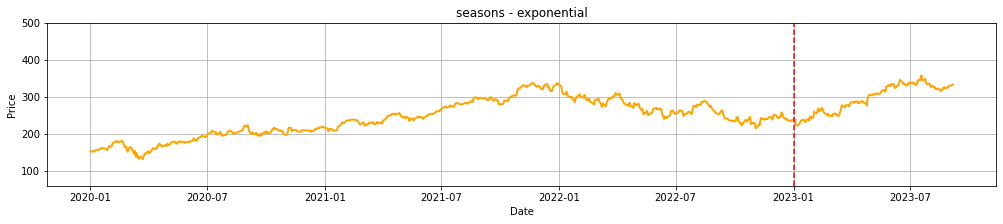

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math

# adjust prices based on month
def SeasonalPriceAdjustment(srsRow):
    if srsRow['Date'].month == 3:
        return srsRow['Price'] * 1.10  # add 10% for March
    elif srsRow['Date'].month == 5:
        return srsRow['Price'] * 0.80  # subtract 20% for May
    elif srsRow['Date'].month == 12:
        return srsRow['Price'] * 0.95  # subtract 20% for May
    else:
        return srsRow['Price']

def SimulatedData(strSeasonality,strFunction,blnRealData=False):
    
    # start and end dates
    strStart = "2020-01-01"
    strEnd   = "2023-09-06"
    strNewYear2023 = "2023-01-01"
    datStart = datetime.strptime(strStart, "%Y-%m-%d")
    datEnd   = datetime.strptime(strEnd,   "%Y-%m-%d")
    tstStartTest = datetime.strptime(strNewYear2023,"%Y-%m-%d")

    # date range
    ldatSimulatedDates = list(pd.date_range(start=datStart, end=datEnd, freq='D'))
    
    if blnRealData:
        dfrSimulatedData = dfrArima[["Date","Price","Differences"]].copy()
        dfrSimulatedData = dfrSimulatedData[(dfrSimulatedData['Date'] >= strStart) & (dfrSimulatedData['Date'] <= strEnd)]
    else:
    
        # define noise with a standard deviation of 10%
        fltNoiseMean = 1
        fltNoiseStdDev = 0.05

        # underlying function
        fltConstant = 100
        fltSlope = 0.09
        x0 = 100
        x1000 = 300
        t1000 = 1000
        k = (math.log(x1000) - math.log(x0)) / t1000

        # Create lfltPrices using list comprehension
        length = len(ldatSimulatedDates)
        if strFunction=="constant":
            lfltPrices = [fltConstant + 0 * fltSlope for intIndex in range(length)]
        if strFunction=="linear":
            lfltPrices = [fltConstant + intIndex * fltSlope for intIndex in range(length)]
        if strFunction=="exponential":
            lfltPrices = [x0 * np.exp(k * intIndex) for intIndex in range(length)]

        # create dataframe
        dfrSimulatedData = pd.DataFrame({'Date': ldatSimulatedDates, 'Price': lfltPrices})

        # Apply the adjustment function to the "Price" column
        if strSeasonality == "seasons":
            dfrSimulatedData['Price'] = dfrSimulatedData.apply(SeasonalPriceAdjustment, axis=1)    

        # add noise
        for index, srsRow in dfrSimulatedData.iterrows():
            fltNoise = np.random.normal(fltNoiseMean, fltNoiseStdDev)
            dfrSimulatedData.at[index, 'Price'] = dfrSimulatedData.at[index, 'Price'] * fltNoise
            
        # differencing
        dfrSimulatedData['Differences'] = dfrSimulatedData['Price'].diff()
        dfrSimulatedData.at[0,'Differences'] = 0 

    # Plot the data
    plt.figure(figsize=(17, 3))
    plt.plot(dfrSimulatedData['Date'], dfrSimulatedData['Price'], color='orange', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f"{strSeasonality} - {strFunction}")
    plt.ylim(60, 500)
    plt.grid(True)
    plt.axvline(x=tstStartTest, color='red', linestyle='--')
    plt.show()
    
    # finalize
    return dfrSimulatedData

# simulated datasets
ddfrDatasets = {}
astrFunctions = ["constant","linear","exponential"]
astrSeasonalities = ["no seasons","seasons"]
p("Simulated data".upper())
for strSeasonality in astrSeasonalities:
    for strFunction in astrFunctions:
        ddfrDatasets[f"{strFunction} - {strSeasonality}"] = SimulatedData(strSeasonality,strFunction,blnRealData=False)

# real dataset      
ddfrDatasets["real"] = SimulatedData(strSeasonality,strFunction,blnRealData=True)

In [6]:
# for compatibility with tutorial
blnShown = False
for strKey, dfrCurr in ddfrDatasets.items():
    ### dfrCurr.drop(columns=["Differences"], inplace=True)
    dfrCurr.set_index("Date", inplace=True)
    if not blnShown:
        p("Example:")
        p(strKey, dfrCurr.shape)
        u.DisplayDataFrame(dfrCurr.head(3))
        blnShown = True

Example:
constant - no seasons (1345, 2)


,Price,Differences
Date,,
2020-01-01,99.713016,0.000000
2020-01-02,90.844840,-8.868176
2020-01-03,100.484556,9.639716


## Dickey-Fuller test<a class="anchor" id="DickeyFullerTest"></a>
[TOC](#TOC)

__Goal__
* The Dickey-Fuller test checks if the data is stationary or not. 

In [7]:
from statsmodels.tsa.stattools import adfuller

def DickeyFullerTest(dfrSource):
    '''
    Calculates Dickey-Fuller test and dsplays results
    When       Who What
    2023-09-22 dh  Created
    '''
    tvarResults = adfuller(dfrSource, autolag = 'AIC')
    p("1. ADF : ",tvarResults[0])
    p("2. P-Value : ", tvarResults[1])
    p("3. Number of lags: ", tvarResults[2])
    p("4. Number of observations used for ADF regression and critical values calculation :", tvarResults[3])
    p("5. Critical Values :")
    for strKey, fltValue in tvarResults[4].items():
        p(f"\t{strKey}:\t{round(fltValue,3)}")
        
    # finalize
    strStationary = "yes" if tvarResults[1] < 0.05 else ""
    return {"ADF":tvarResults[0],"p":tvarResults[1],"stationary": strStationary,"lags":tvarResults[2]}

def DickeyFullerOnAllDatasets(strColumn):
    p("Dickey-Fuller test".upper())
    ldvarResults = []
    for strKey, dfrCurr in ddfrDatasets.items():
        p()
        p(f"• {strKey}".upper())
        dfrTrainTest = dfrCurr[[strColumn]]
        dfrTrain = dfrTrainTest[dfrTrainTest.index < '2023-01-01']
        dvarResults = DickeyFullerTest(dfrTrain)
        dvarResults["Dataset"] = strKey
        ldvarResults.append(dvarResults)
    dfrOverview = pd.DataFrame(ldvarResults)
    dfrOverview['ADF'] = dfrOverview['ADF'].round(3)
    dfrOverview['p'] = dfrOverview['p'].round(3)
    p()
    p("Overview".upper())
    u.DisplayDataFrame(dfrOverview)
    
DickeyFullerOnAllDatasets("Price")

DICKEY-FULLER TEST

• CONSTANT - NO SEASONS
1. ADF :  -33.115091652237744
2. P-Value :  0.0
3. Number of lags:  0
4. Number of observations used for ADF regression and critical values calculation : 1095
5. Critical Values :
	1%:	-3.436
	5%:	-2.864
	10%:	-2.568

• LINEAR - NO SEASONS
1. ADF :  -0.7004142222809017
2. P-Value :  0.846642215803367
3. Number of lags:  17
4. Number of observations used for ADF regression and critical values calculation : 1078
5. Critical Values :
	1%:	-3.436
	5%:	-2.864
	10%:	-2.568

• EXPONENTIAL - NO SEASONS
1. ADF :  2.0968839989980044
2. P-Value :  0.9987863449611367
3. Number of lags:  21
4. Number of observations used for ADF regression and critical values calculation : 1074
5. Critical Values :
	1%:	-3.436
	5%:	-2.864
	10%:	-2.568

• CONSTANT - SEASONS
1. ADF :  -5.101436330658448
2. P-Value :  1.392606450519287e-05
3. Number of lags:  5
4. Number of observations used for ADF regression and critical values calculation : 1090
5. Critical Values :
	1%:	

,ADF,p,stationary,lags,Dataset
0,-33.115,0.000,yes,0,constant - no seasons
1,-0.700,0.847,,17,linear - no seasons
2,2.097,0.999,,21,exponential - no seasons
3,-5.101,0.000,yes,5,constant - seasons
4,-1.684,0.439,,8,linear - seasons
5,-0.521,0.888,,7,exponential - seasons
6,-1.834,0.364,,8,real


__Comments__
* ADF stands for "Augmented Dickey-Fuller Test".
* The two data simulations named __"constant"__ are detected as __stationary__.
* All the other data sets are not stationary.
    * i.e. the __real data__, too, is __not stationary__.

In [8]:
DickeyFullerOnAllDatasets("Differences")

DICKEY-FULLER TEST

• CONSTANT - NO SEASONS
1. ADF :  -11.628195880395333
2. P-Value :  2.296284160697838e-21
3. Number of lags:  22
4. Number of observations used for ADF regression and critical values calculation : 1073
5. Critical Values :
	1%:	-3.436
	5%:	-2.864
	10%:	-2.568

• LINEAR - NO SEASONS
1. ADF :  -13.669309752157872
2. P-Value :  1.4700458975004753e-25
3. Number of lags:  16
4. Number of observations used for ADF regression and critical values calculation : 1079
5. Critical Values :
	1%:	-3.436
	5%:	-2.864
	10%:	-2.568

• EXPONENTIAL - NO SEASONS
1. ADF :  -12.49520650664423
2. P-Value :  2.886402549654567e-23
3. Number of lags:  20
4. Number of observations used for ADF regression and critical values calculation : 1075
5. Critical Values :
	1%:	-3.436
	5%:	-2.864
	10%:	-2.568

• CONSTANT - SEASONS
1. ADF :  -21.746835195558646
2. P-Value :  0.0
3. Number of lags:  4
4. Number of observations used for ADF regression and critical values calculation : 1091
5. Critical Valu

,ADF,p,stationary,lags,Dataset
0,-11.628,0.0,yes,22,constant - no seasons
1,-13.669,0.0,yes,16,linear - no seasons
2,-12.495,0.0,yes,20,exponential - no seasons
3,-21.747,0.0,yes,4,constant - seasons
4,-16.688,0.0,yes,7,linear - seasons
5,-18.057,0.0,yes,6,exponential - seasons
6,-11.774,0.0,yes,7,real


__Comments__
* By __differencing once__ all datasets become __stationary__ (i.e. p < 5%).
* Those two datasets which were stationary before differencing stay stationary.
* The real data will be analyzed using __ARIMA(p,1,q)__.

## ARIMA / SARIMA <a class="anchor" id="ArimaSarima"></a>
[TOC](#TOC)

### Auto-ARIMA: Best model parameters p, d, q <a class="anchor" id="AutoArima"></a>
[TOC](#TOC)

In [9]:
from pmdarima import auto_arima
import warnings
def AutoArima(strColumn,blnShowDetails=False):

    # const
    cintMaxDefinition = 100
    
    # init
    ddvarAutoArimaResults = {}
    lstrDatasets = []
    lstrModels = []
    lintP = []
    lintD = []
    lintQ = []
    lfltSeconds = []
    
    # analyze each dataset
    for strKey, dfrCurr in ddfrDatasets.items():

        # run ARIMA / SARIMA
        warnings.filterwarnings("ignore") # ignore harmless warnings
        dfrTrainTest = dfrCurr[[strColumn]]
        dfrTrain = dfrTrainTest[dfrTrainTest.index < '2023-01-01']
        u.StopWatch()
        objArimaStepwiseFit = auto_arima(dfrTrain[strColumn],suppress_warnings=True, max_p=cintMaxDefinition, max_d=1, max_q=cintMaxDefinition)
        fltTimeUsed = u.StopWatch("seconds",blnAsFloat=True)
        if blnShowDetails:
            p()
            p(f"• {strKey}".upper())            
            p(objArimaStepwiseFit.summary())
        
        # remember model
        tintArimaOrder = objArimaStepwiseFit.order
        tinSeasonalOrder = objArimaStepwiseFit.seasonal_order
        if tinSeasonalOrder is None:
            strModel = f"ARIMA({tintArimaOrder[0]},{tintArimaOrder[1]},{tintArimaOrder[2]})"
        else:
            strModel = f"SARIMAX({tintArimaOrder[0]},{tintArimaOrder[1]},{tintArimaOrder[2]})x({tinSeasonalOrder[0]},{tinSeasonalOrder[1]},{tinSeasonalOrder[2]},{tinSeasonalOrder[3]})"        
        lstrDatasets.append(strKey)
        lstrModels.append(strModel)
        
        # remember parameters
        lintP.append(tintArimaOrder[0])
        lintD.append(tintArimaOrder[1])
        lintQ.append(tintArimaOrder[2])
        lfltSeconds.append(fltTimeUsed)
    
    # finalize
    return {"Dataset": lstrDatasets,"Model":lstrModels,"p":lintP,"d":lintD,"q":lintQ,"Seconds":lfltSeconds}

# run auto-ARIMA
p("ARIMA / SARIMA".upper())
p("(... takes about 50 seconds.)")
p()

# check with both variables, raw vs. differenced
ddvarAutoArimaResults = {}
for strVariable in ["Price","Differences"]:
    
    # run analysis
    ddvarAutoArimaResults[strVariable] = AutoArima(strVariable)

    # report
    p(f"VARIABLE '{strVariable}'")
    p(f"- Models resulting from different datasets".upper())
    u.DisplayDataFrame(pd.DataFrame(ddvarAutoArimaResults[strVariable]))

ARIMA / SARIMA
(... takes about 50 seconds.)

VARIABLE 'Price'
- MODELS RESULTING FROM DIFFERENT DATASETS


,Dataset,Model,p,d,q,Seconds
0,constant - no seasons,"SARIMAX(0,0,0)x(0,0,0,0)",0,0,0,1.491068
1,linear - no seasons,"SARIMAX(11,1,0)x(0,0,0,0)",11,1,0,21.501142
2,exponential - no seasons,"SARIMAX(1,1,2)x(0,0,0,0)",1,1,2,4.905114
3,constant - seasons,"SARIMAX(3,0,2)x(0,0,0,0)",3,0,2,14.686921
4,linear - seasons,"SARIMAX(2,1,3)x(0,0,0,0)",2,1,3,9.583392
5,exponential - seasons,"SARIMAX(0,1,1)x(0,0,0,0)",0,1,1,2.055994
6,real,"SARIMAX(0,1,1)x(0,0,0,0)",0,1,1,1.880306


VARIABLE 'Differences'
- MODELS RESULTING FROM DIFFERENT DATASETS


,Dataset,Model,p,d,q,Seconds
0,constant - no seasons,"SARIMAX(13,0,0)x(0,0,0,0)",13,0,0,38.216896
1,linear - no seasons,"SARIMAX(11,0,0)x(0,0,0,0)",11,0,0,20.435704
2,exponential - no seasons,"SARIMAX(1,0,2)x(0,0,0,0)",1,0,2,4.691257
3,constant - seasons,"SARIMAX(0,0,1)x(0,0,0,0)",0,0,1,1.870568
4,linear - seasons,"SARIMAX(1,0,2)x(0,0,0,0)",1,0,2,4.482311
5,exponential - seasons,"SARIMAX(0,0,1)x(0,0,0,0)",0,0,1,1.433903
6,real,"SARIMAX(0,0,1)x(0,0,0,0)",0,0,1,2.101859


__Comments__
* Auto-ARIMA detects whether differencing is necessary or not.
    * When using `Price`: differencing once is necessary (`d = 1`), except for constant simulations (see result further above).
    * When using `Differences`: differencing is not necessary.
* That implies that __manual differencing__ is __not necessary__: this is integrated into the ARIMA model by parameter `d`.
* `q` is not depending on whether we work on original data or differenced data.
* `p` seems to be volatile.
* The model for the Microsoft dataset is __ARIMA(0,0,1)__.

### Fit ARIMA <a class="anchor" id="FitArima"></a>

FIRST 7 PREDICTIONS:
- constant - no seasons:    99.8127     99.8127     99.8127     99.8127     99.8127     99.8127     99.8127
- linear - no seasons:      197.6446     196.6457     195.909     195.707     196.6144     197.3324     195.5197
- exponential - no seasons: 326.2583     325.3999     326.0816     325.5403     325.9701     325.6288     325.8998
- constant - seasons:       94.6773     95.213     95.4216     95.5979     95.7644     95.9225     96.0721
- linear - seasons:         180.2178     181.9219     180.3714     181.7488     180.5599     181.549     180.7669
- exponential - seasons:    316.5122     316.5122     316.5122     316.5122     316.5122     316.5122     316.5122
- real:                     238.0855     238.0855     238.0855     238.0855     238.0855     238.0855     238.0855


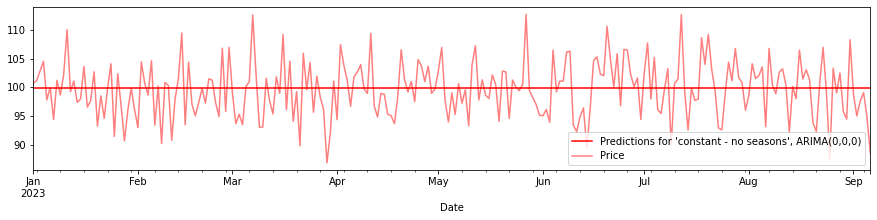

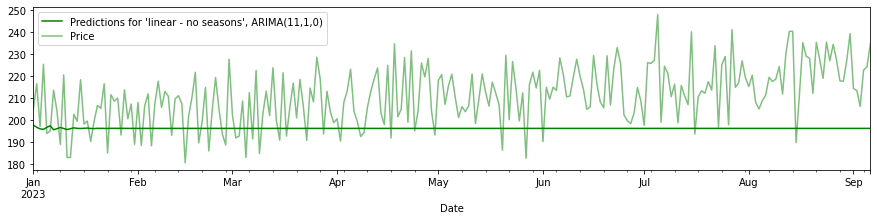

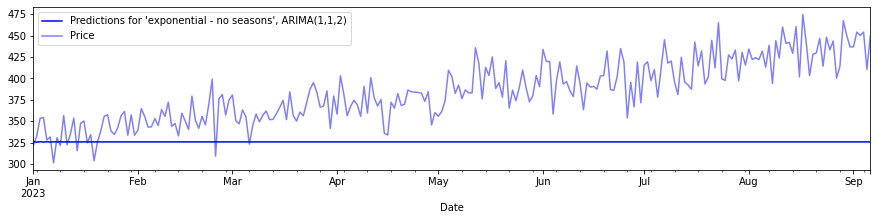

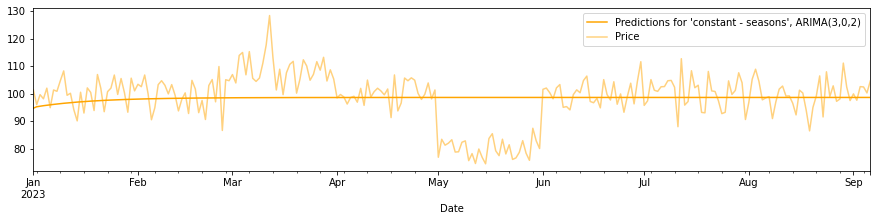

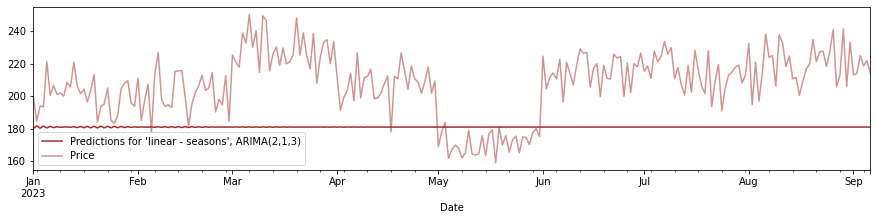

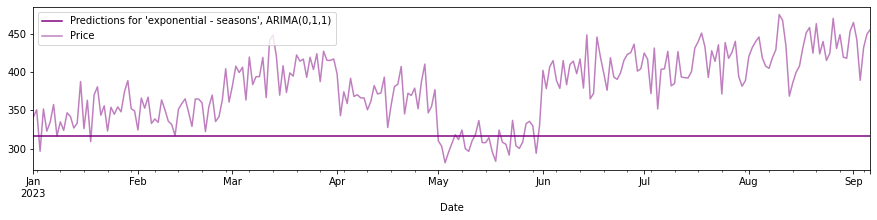

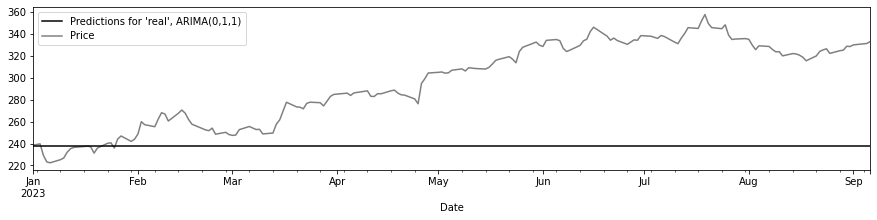

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# use ARIMA models on variable "Price" only
dvarAutoArimaResults = ddvarAutoArimaResults["Price"]
dfrAutoArimaResults = pd.DataFrame(dvarAutoArimaResults)

# init
strNewYear2023 = "2023-01-01"
tstStartTest = datetime.strptime(strNewYear2023,"%Y-%m-%d")
intIndex=0
lstrColors = ["red","green","blue","orange","brown","purple","black"]

# examples
blnShowIndividualPredictions = True
if blnShowIndividualPredictions:
    cintExamples = 7
    p(f"First {cintExamples} predictions:".upper())
    
# fit ARIMA and plot predictions for each dataset    
for strDataset, dfrCurr in ddfrDatasets.items():

    # look-up p,d,q
    srsRecord = dfrAutoArimaResults[dfrAutoArimaResults["Dataset"] == strDataset].iloc[0]
    intP = srsRecord["p"]
    intD = srsRecord["d"]
    intQ = srsRecord["q"]
    
    # split train/test
    dfrTrain = dfrCurr[dfrCurr.index < strNewYear2023][["Price"]]
    dfrTest  = dfrCurr[dfrCurr.index >= strNewYear2023][["Price"]]
    
    # fit model
    objArimaModel = ARIMA(dfrTrain['Price'],order=(intP,intD,intQ))
    objArimaModel = objArimaModel.fit()
    if False:
        p(objArimaModel.summary())

    # predict
    intStart = len(dfrTrain)
    intEnd   = len(dfrTrain)+len(dfrTest)-1
    pred  = objArimaModel.predict(start=intStart,end=intEnd,typ='levels').rename(f"Predictions for '{strDataset}', ARIMA({intP},{intD},{intQ})")
    
    if blnShowIndividualPredictions:

        srsExamples = pred.copy()
        srsExamples = srsExamples.round(4)[:cintExamples]
        strChain = u.JoinAnyType(srsExamples, '     ')
        strExtendedDataset = (strDataset + ":").ljust(len("exponential - no seasons:"), " ") 
        p(f"- {strExtendedDataset} {strChain}")
    
    # plot
    strColor = lstrColors[intIndex]
    plt.figure(figsize=(15, 3)) 
    pred.plot(legend=True,color=strColor)
    dfrTest['Price'].plot(legend=True,color=strColor,alpha=0.5)    
    
    # prepare next loop
    intIndex+=1

__Conclusions__
* ARIMA seems not to be able to fit and predict the time series in a reasonable way:
    * 2 x 3 simulations.
    * real Microsoft time series.
* In 5 out of the 7 datasets the predictions are constant.
    * Exceptions with minor variation:
        * `331.9627 333.7621 333.6211 333.6321 333.6312 333.6313 333.6313` for 'exponential - no seasons'.
        * ` 97.5177  97.8213  97.7841  97.7705  97.7766  97.8185  97.864` for 'constant - seasons'.